In [79]:
import sqlite3
import csv
import numpy as np
from sklearn import preprocessing
from datetime import datetime
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

In [80]:
request = {'mood': 4, 'body': 3, 'money': -3, 'time': -3}

In [81]:
# データベースに接続
conn = sqlite3.connect("recipe.db")
cursor = conn.cursor()

# データベースからデータを取得
cursor.execute('SELECT * FROM recipe')
result = cursor.fetchall()

# 取得したデータをリストに格納
recipe_list = []
for row in result:
    recipe_list.append(list(row))

# データベース接続を閉じる
cursor.close()
conn.close()

In [82]:
# レシピデータの気分と分類を取得し標準化を行う

# レシピデータの気分のラベルを取得['mood', 'body', 'money', 'time']
moods = recipe_list[0][4:8]

# レシピデータの気分と分類を取得
recipe_list_syusyoku = []
recipe_list_syusai = []
recipe_list_hukusai = []
recipe_list_mood = []
recipe_list_body = []
recipe_list_money = []
recipe_list_time = []

# レシピデータの気分と分類をリストに格納(先頭行のラベルを除く)
for row in recipe_list[1:]:
    recipe_list_syusyoku.append(float(list(row)[1]))  # 「主食」の行のみを抽出
    recipe_list_syusai.append(float(list(row)[2]))    # 「主菜」の行のみを抽出
    recipe_list_hukusai.append(float(list(row)[3]))   # 「副菜」の行のみを抽出
    recipe_list_mood.append(float(list(row)[4]))      # 「精神」の行のみを抽出
    recipe_list_body.append(float(list(row)[5]))      # 「身体」の行のみを抽出
    recipe_list_money.append(float(list(row)[6]))     # 「経済」の行のみを抽出
    recipe_list_time.append(float(list(row)[7]))      # 「時間」の行のみを抽出

# レシピデータの時間の値を標準化
recipe_list_time_std = preprocessing.scale(recipe_list_time)

# レシピデータの気分の値を標準化した値をリストに格納
recipe_moods_std = [recipe_list_mood, recipe_list_body, recipe_list_money, recipe_list_time_std]

# POSTメソッドから取得した気分の値を取得
# (例)  [('mood', '-1'), ('body', '-2'), ('money', '-2'), ('time', '1')]
mood_values = [float(request[mood]) for mood in moods]


In [83]:
# ユーザの気分の値とレシピデータの気分の値のユークリッド距離を算出
squared_diff = []

for mood_index, mood_value in enumerate(mood_values):
    if mood_value != 0:

        diff_mood = np.array(recipe_moods_std[mood_index]) - mood_value # レシピデータの気分とPOSTメソッドから取得したmoodの値の差を計算
        squared_diff_mood = np.square(diff_mood)                        # 差の2乗を計算
    else:
        # スライダーが0を選択しているときはユークリッド距離を計算しない
        squared_diff_mood = np.zeros(len(recipe_moods_std[0]), dtype=float)
    
    squared_diff.append(squared_diff_mood)

# 各列の合計を求める
squared_diff_columns_sum = np.sum(squared_diff, axis=0)

# 各要素の平方根を求める
euclidean_distance_list = np.sqrt(squared_diff_columns_sum)

In [84]:
# ユークリッド距離の値のリストとレシピデータのリストを結合
# 距離の値のリストとデータベースから取得したデータのリストを結合
combined_list = []
recipe_list_deleted_label = recipe_list[1:] # 先頭行のラベルを除く
for row_num in range(len(recipe_list_deleted_label)):
    recipe_list_deleted_label[row_num].append(euclidean_distance_list[row_num])
    combined_list.append(recipe_list_deleted_label[row_num])

# 距離に基づいてリストをソート(昇順)
sorted_list = sorted(combined_list, key=lambda x: x[8])

# ランキングスコアを逆数に変換
sorted_list_reciprocal = []

for i in range(len(sorted_list)):
    sorted_item_reciprocal = sorted_list[i][0:8]
    sorted_list_reciprocal.append(sorted_item_reciprocal)
    sorted_list_reciprocal[i].append(1/sorted_list[i][8])

# 多様性リランキング前のスコアを保存
sorted_list_no_reranking = sorted_list_reciprocal.copy()

In [85]:
# ランキングスコアを正規化
# スコアだけを抽出して別のリストに格納
list_score = []
for row in sorted_list_reciprocal:
    list_score.append(row[8])

# スコアを正規化
list_score = preprocessing.minmax_scale(list_score, feature_range=(0, 1))

# 正規化したスコアをリストに戻す
normalized_score_list = []
for i in range(len(sorted_list_reciprocal)):
    normalized_score_list.append(sorted_list_reciprocal[i][0:8])
    normalized_score_list[i].append(list_score[i])

In [86]:
# 多様性を考慮したリランキングを行う
# コサイン類似度を計算したリストを返す
def similarity(i, R):

    v1 = i[1:4]
    sim_list = []
    eps = 1e-8

    for j in R:
        v2 = j[1:4]
        sim = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)) + eps
        sim_list.append(sim)
    return sim_list

# 検索結果のリストを多様性を考慮してリランキング
def select_item_id(sorted_list, R, alpha):
    C = sorted_list
    max_score = -10
    max_score_item_id = -10
    for i in C:
        if len(R) == 0:
            return i

        score = alpha * i[8] - (1 - alpha) * max(similarity(i, R))

        if score > max_score:
            max_score = score
            max_score_item_id = i
    return max_score_item_id

# 多様性を考慮したリランキングを行う
def greedy_reranking(C, N, alpha):
    results = []
    while len(results) < N:
        doc_id = select_item_id(C, results, alpha)
        results.append(doc_id)
        C.remove(doc_id)
        
    return results

# 結果をcsvファイルに書き込む
# リストをresultに格納
result_list = []
#alpha_list = [i/20 for i in range(0, 21)]
alpha_list = [0.0, 0.25, 0.5, 0.75, 1.0]
#alpha_list = [1]
R = 10
for alpha in alpha_list:
    C = normalized_score_list.copy()
    recommended_recipe_list = greedy_reranking(C, R, alpha)
    result_list.append(recommended_recipe_list)

In [87]:
'''
# リストをcsvファイルに書き込む
def write_csv(list):
    DATE = datetime.now().strftime("%Y%m%d_%H%M%S")
    FILE_NAME = "./result/data_"+DATE+".csv"
    with open(FILE_NAME, 'w', newline='') as f:
        writer = csv.writer(f)
        for row in list:
            writer.writerows(row)
        f.close()

write_csv(result_list)
'''

'\n# リストをcsvファイルに書き込む\ndef write_csv(list):\n    DATE = datetime.now().strftime("%Y%m%d_%H%M%S")\n    FILE_NAME = "./result/data_"+DATE+".csv"\n    with open(FILE_NAME, \'w\', newline=\'\') as f:\n        writer = csv.writer(f)\n        for row in list:\n            writer.writerows(row)\n        f.close()\n\nwrite_csv(result_list)\n'

In [88]:
result_list

[[['親子丼', 0.5, 0.5, 0.0, 3, 3, -3, 10, 0.9999999999999999],
  ['ポテトサラダ', 0.0, 0.0, 1.0, 4, 1, -3, 15, 0.7604181176451527],
  ['鶏の照り焼き', 0.0, 1.0, 0.0, 4, 3, -4, 10, 0.9999999999999999],
  ['チャーハン', 1.0, 0.0, 0.0, 1, 3, -3, 10, 0.5948294481159274],
  ['豚汁\t', 0.0, 0.5, 0.5, 4, 3, 1, 30, 0.4103624093315902],
  ['ビビンパ',
   0.333333333,
   0.333333333,
   0.333333333,
   3,
   5,
   1,
   30,
   0.35132271641727275],
  ['カルボナーラ', 0.5, 0.5, 0.0, 4, 2, -3, 15, 0.9505774313943868],
  ['ナポリタン', 0.5, 0.5, 0.0, 3, 4, -3, 20, 0.8376434235000937],
  ['ポモドーロ', 0.5, 0.5, 0.0, 3, 3, -2, 30, 0.7677633242971337],
  ['蕎麦屋直伝\u3000とり南蛮そば', 0.5, 0.5, 0.0, 2, 2, -3, 12, 0.7295829255235902]],
 [['親子丼', 0.5, 0.5, 0.0, 3, 3, -3, 10, 0.9999999999999999],
  ['ポテトサラダ', 0.0, 0.0, 1.0, 4, 1, -3, 15, 0.7604181176451527],
  ['鶏の照り焼き', 0.0, 1.0, 0.0, 4, 3, -4, 10, 0.9999999999999999],
  ['チャーハン', 1.0, 0.0, 0.0, 1, 3, -3, 10, 0.5948294481159274],
  ['豚汁\t', 0.0, 0.5, 0.5, 4, 3, 1, 30, 0.4103624093315902],
  ['カルボナーラ', 

In [89]:
Y_syusyoku = []
Y_syusai = []
Y_hukusai = []

for alpha_index, alpha in enumerate(alpha_list):
    syusyoku = 0
    syusai = 0
    hukusai = 0
    goukei = 0
    for row in result_list[alpha_index]:

        syusyoku += float(row[1])
        syusai += float(row[2])
        hukusai += float(row[3])
        goukei += float(row[1]) + float(row[2]) + float(row[3])
    
    Y_syusyoku.append(syusyoku / goukei * 100)
    Y_syusai.append(syusai / goukei * 100)
    Y_hukusai.append(hukusai / goukei * 100)
    print("α = ", alpha)
    print("主食割合: ", round(syusyoku / goukei * 100, 2), "%")
    print("主菜割合: ", round(syusai / goukei * 100, 2), "%")
    print("副菜割合: ", round(hukusai / goukei * 100, 2), "%")

α =  0.0
主食割合:  38.33 %
主菜割合:  43.33 %
副菜割合:  18.33 %
α =  0.25
主食割合:  33.33 %
主菜割合:  48.33 %
副菜割合:  18.33 %
α =  0.5
主食割合:  30.0 %
主菜割合:  50.0 %
副菜割合:  20.0 %
α =  0.75
主食割合:  25.0 %
主菜割合:  55.0 %
副菜割合:  20.0 %
α =  1.0
主食割合:  25.0 %
主菜割合:  55.0 %
副菜割合:  20.0 %


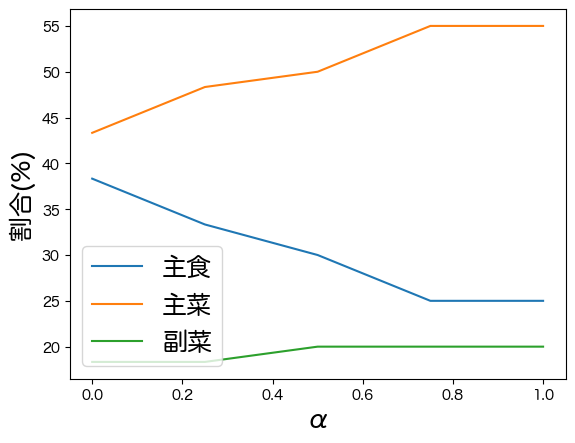

In [90]:
X = alpha_list

plt.xlabel("α", fontsize=18)
plt.ylabel("割合(%)",  fontsize=18)


#グラフプロット準備
plt.plot(X, Y_syusyoku, label="主食")
plt.plot(X, Y_syusai, label="主菜")
plt.plot(X, Y_hukusai, label="副菜")


plt.legend(loc="lower left", fontsize=18)

#グラフ出力
plt.show()

In [91]:
Y_syusyoku = []
Y_syusai = []
Y_hukusai = []

# result_listの中身を表示
for alpha_index, alpha in enumerate(alpha_list):
    print("α = ", alpha)
    syusyoku = 0
    syusai = 0
    hukusai = 0
    goukei = 0
    for row in result_list[alpha_index]:
        print("料理名：", row[0], "主食：", row[1], "主菜：", row[2], "副菜：", row[3], "スコア：", row[8])
        syusyoku += float(row[1])
        syusai += float(row[2])
        hukusai += float(row[3])
        goukei += float(row[1]) + float(row[2]) + float(row[3])
        
        Y_syusyoku.append(syusyoku / goukei * 100)
        Y_syusai.append(syusai / goukei * 100)
        Y_hukusai.append(hukusai / goukei * 100)
    print("主食割合: ", round(syusyoku / goukei * 100, 2), "%")
    print("主菜割合: ", round(syusai / goukei * 100, 2), "%")
    print("副菜割合: ", round(hukusai / goukei * 100, 2), "%")
    print("\n")

α =  0.0
料理名： 親子丼 主食： 0.5 主菜： 0.5 副菜： 0.0 スコア： 0.9999999999999999
料理名： ポテトサラダ 主食： 0.0 主菜： 0.0 副菜： 1.0 スコア： 0.7604181176451527
料理名： 鶏の照り焼き 主食： 0.0 主菜： 1.0 副菜： 0.0 スコア： 0.9999999999999999
料理名： チャーハン 主食： 1.0 主菜： 0.0 副菜： 0.0 スコア： 0.5948294481159274
料理名： 豚汁	 主食： 0.0 主菜： 0.5 副菜： 0.5 スコア： 0.4103624093315902
料理名： ビビンパ 主食： 0.333333333 主菜： 0.333333333 副菜： 0.333333333 スコア： 0.35132271641727275
料理名： カルボナーラ 主食： 0.5 主菜： 0.5 副菜： 0.0 スコア： 0.9505774313943868
料理名： ナポリタン 主食： 0.5 主菜： 0.5 副菜： 0.0 スコア： 0.8376434235000937
料理名： ポモドーロ 主食： 0.5 主菜： 0.5 副菜： 0.0 スコア： 0.7677633242971337
料理名： 蕎麦屋直伝　とり南蛮そば 主食： 0.5 主菜： 0.5 副菜： 0.0 スコア： 0.7295829255235902
主食割合:  38.33 %
主菜割合:  43.33 %
副菜割合:  18.33 %


α =  0.25
料理名： 親子丼 主食： 0.5 主菜： 0.5 副菜： 0.0 スコア： 0.9999999999999999
料理名： ポテトサラダ 主食： 0.0 主菜： 0.0 副菜： 1.0 スコア： 0.7604181176451527
料理名： 鶏の照り焼き 主食： 0.0 主菜： 1.0 副菜： 0.0 スコア： 0.9999999999999999
料理名： チャーハン 主食： 1.0 主菜： 0.0 副菜： 0.0 スコア： 0.5948294481159274
料理名： 豚汁	 主食： 0.0 主菜： 0.5 副菜： 0.5 スコア： 0.4103624093315902
料理名： カルボナーラ 主食： 0.5 主

In [92]:
# 前回のランキングから何位変化したかを表示

Y_syusyoku = []
Y_syusai = []
Y_hukusai = []

for alpha_index, alpha in enumerate(alpha_list):
    print("α = ", alpha)
    syusyoku = 0
    syusai = 0
    hukusai = 0
    goukei = 0
    if alpha_index == 0:
        for row_index, row in enumerate(result_list[alpha_index]):
            syusyoku += float(row[1])
            syusai += float(row[2])
            hukusai += float(row[3])
            goukei += float(row[1]) + float(row[2]) + float(row[3])
            print("料理名：", row[0][0:3], "今回の順位：", row_index + 1, "前回の順位：--", "順位変化：--", "主食：", round(syusyoku, 2), "主菜：", round(syusai, 2), "副菜：", round(hukusai, 2))
            
    else:
        for row_index, row in enumerate(result_list[alpha_index]):
            syusyoku += float(row[1])
            syusai += float(row[2])
            hukusai += float(row[3])
            found = False  # 料理が前回のリストに見つかったかどうかを示すフラグ
            for pre_row_index, pre_row in enumerate(result_list[alpha_index - 1]):
                if row[0] == pre_row[0]:
                    print("料理名：", row[0][0:3], "今回の順位：", row_index + 1, "前回の順位：", pre_row_index + 1, "順位変化：", pre_row_index - row_index, "主食：", round(syusyoku, 2), "主菜：", round(syusai, 2), "副菜：", round(hukusai, 2))
                    found = True  # 料理が見つかったことをマーク
                    break
            if not found:
                print("料理名：", row[0][0:3], "今回の順位：", row_index + 1, "前回の順位：--", "順位変化：--", "主食：", round(syusyoku, 2), "主菜：", round(syusai, 2), "副菜：", round(hukusai, 2))
    print("\n")

α =  0.0
料理名： 親子丼 今回の順位： 1 前回の順位：-- 順位変化：-- 主食： 0.5 主菜： 0.5 副菜： 0.0
料理名： ポテト 今回の順位： 2 前回の順位：-- 順位変化：-- 主食： 0.5 主菜： 0.5 副菜： 1.0
料理名： 鶏の照 今回の順位： 3 前回の順位：-- 順位変化：-- 主食： 0.5 主菜： 1.5 副菜： 1.0
料理名： チャー 今回の順位： 4 前回の順位：-- 順位変化：-- 主食： 1.5 主菜： 1.5 副菜： 1.0
料理名： 豚汁	 今回の順位： 5 前回の順位：-- 順位変化：-- 主食： 1.5 主菜： 2.0 副菜： 1.5
料理名： ビビン 今回の順位： 6 前回の順位：-- 順位変化：-- 主食： 1.83 主菜： 2.33 副菜： 1.83
料理名： カルボ 今回の順位： 7 前回の順位：-- 順位変化：-- 主食： 2.33 主菜： 2.83 副菜： 1.83
料理名： ナポリ 今回の順位： 8 前回の順位：-- 順位変化：-- 主食： 2.83 主菜： 3.33 副菜： 1.83
料理名： ポモド 今回の順位： 9 前回の順位：-- 順位変化：-- 主食： 3.33 主菜： 3.83 副菜： 1.83
料理名： 蕎麦屋 今回の順位： 10 前回の順位：-- 順位変化：-- 主食： 3.83 主菜： 4.33 副菜： 1.83


α =  0.25
料理名： 親子丼 今回の順位： 1 前回の順位： 1 順位変化： 0 主食： 0.5 主菜： 0.5 副菜： 0.0
料理名： ポテト 今回の順位： 2 前回の順位： 2 順位変化： 0 主食： 0.5 主菜： 0.5 副菜： 1.0
料理名： 鶏の照 今回の順位： 3 前回の順位： 3 順位変化： 0 主食： 0.5 主菜： 1.5 副菜： 1.0
料理名： チャー 今回の順位： 4 前回の順位： 4 順位変化： 0 主食： 1.5 主菜： 1.5 副菜： 1.0
料理名： 豚汁	 今回の順位： 5 前回の順位： 5 順位変化： 0 主食： 1.5 主菜： 2.0 副菜： 1.5
料理名： カルボ 今回の順位： 6 前回の順位： 7 順位変化： 1 主食： 2.0 主菜： 2.5 副菜： 1.5
料理名： ビビン 今回の順位： 7 前

In [270]:
result_list[0][0]

['親子丼', 0.5, 0.5, 0.0, 3, 3, -3, 10, 0.9999999999999999]

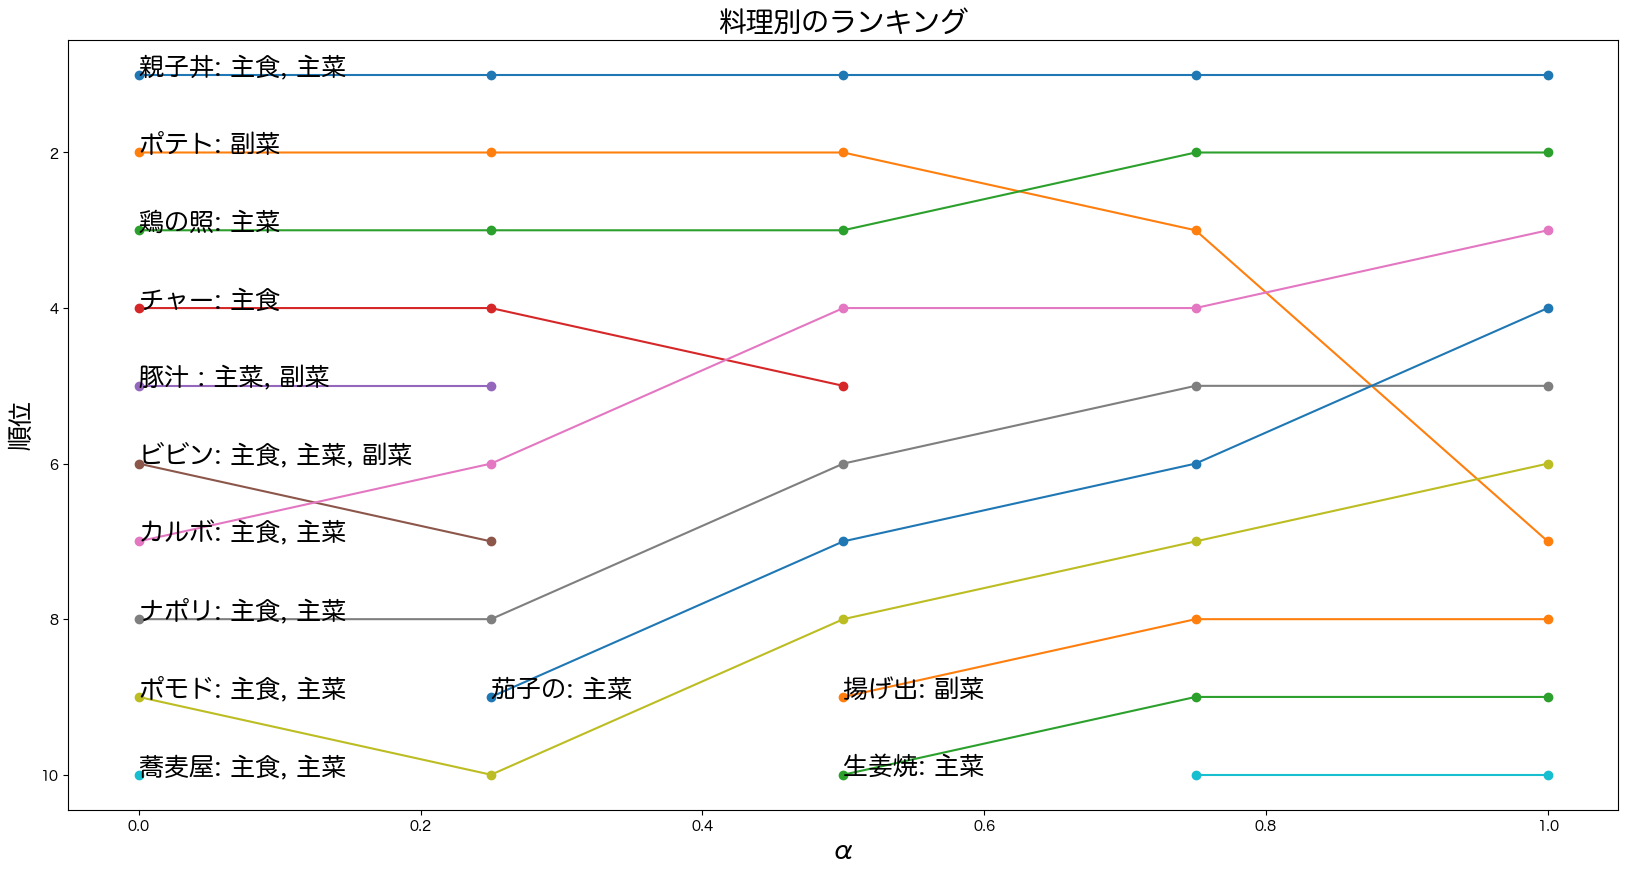

In [326]:


# データを格納するためのリスト
data = []

for alpha_index, alpha in enumerate(alpha_list):
    alpha_data = []
    if alpha_index == 0:
        for row_index, row in enumerate(result_list[alpha_index]):
            alpha_data.append([row[0][0:3], row_index + 1, None, row[1], row[2], row[3]])
    else:
        for row_index, row in enumerate(result_list[alpha_index]):
            found = False  # 料理が前回のリストに見つかったかどうかを示すフラグ
            for pre_row_index, pre_row in enumerate(result_list[alpha_index - 1]):
                if row[0] == pre_row[0]:
                    alpha_data.append([row[0][0:3], row_index + 1, pre_row_index + 1, row[1], row[2], row[3]])
                    found = True  # 料理が見つかったことをマーク
                    break
            if not found:
                alpha_data.append([row[0][0:3], row_index + 1, None , row[1], row[2], row[3]])
    
    data.extend(alpha_data)

# 料理別のランキングを辞書に格納する
dish_data = {}
dish_data_2 = {}
for row in data:
    dish_name = row[0]
    if dish_name not in dish_data:
        dish_data[dish_name] = []
        dish_data_2[dish_name] = row[3:6]

j=0
for i in range(0, len(alpha_list)*10, 10):
    j=j+1
    for row in data[i:i+10]:
        dish_data[row[0]].append(row[1])
    for row2 in dish_data:
        if len(dish_data[row2]) != j:
            dish_data[row2].append(None)

for j in dish_data_2:
    dish_data_2[j].append([])
    if dish_data_2[j][0] != 0:
        dish_data_2[j][3].append("主食")
    if dish_data_2[j][1] != 0:
        dish_data_2[j][3].append("主菜")
    if dish_data_2[j][2] != 0:
        dish_data_2[j][3].append("副菜")

# dish_dataを折れ線グラフにする
# グラフの描画
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

# グラフのタイトルと軸ラベルを設定
ax.set_title('料理別のランキング', fontsize=20)
ax.set_xlabel('α', fontsize=18)
ax.set_ylabel('順位', fontsize=18)
ax.invert_ｙaxis()

# 描画するデータ
for dish_name in dish_data:
    ax.plot(alpha_list, dish_data[dish_name], label=dish_name, marker='o')

k = [next((i for i, x in enumerate(dish_data[dish_name]) if x), None) for dish_name in dish_data]
# グラフの始点にレシピ名を表示
for index, dish_name in enumerate(dish_data):
    ax.text(alpha_list[k[index]], dish_data[dish_name][k[index]], dish_name +': '+ ', '.join(dish_data_2[dish_name][3]), fontsize=18)

# グラフを表示
plt.show()




In [318]:
for j in dish_data_2:
    dish_data_2[j].append([])
    if dish_data_2[j][0] != 0:
        dish_data_2[j][3].append("主食")
    if dish_data_2[j][1] != 0:
        dish_data_2[j][3].append("主菜")
    if dish_data_2[j][2] != 0:
        dish_data_2[j][3].append("副菜")
        

In [321]:
', '.join(dish_data_2["カルボ"][3])

'主食, 主菜'